<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94%EC%83%9D%EC%9C%A1ver3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "./drive/My Drive/Data/lettuce"

/content/drive/My Drive/Data/lettuce


In [3]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [29]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

categoricals = []

FEATURES = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
        ]      
FEATURES_sum= ['DAT', 'obs_time', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량' ]      
FEATURES2 =['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES3 = [ 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES_dacon = ['DAT','obs_time', '내부온도관측치', '내부습도관측치', 'ec관측치' ,'시간당총광량']
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)



Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [113]:
def get_time(x, numbers):
    x['DAT'] = x['DAT'].map(lambda x: f'20{numbers}010'+ str(x+1)+' ' if x<9 else f'20{numbers}01'+ str(x+1)+' ' )
    x['obs_time']=x['obs_time'].map(lambda x: x.split(':')[0]+ x.split(':')[1])
    x['시간'] = x['DAT']+x['obs_time']
    x['시간']=pd.to_datetime(x['시간'], format ='%Y%m%d %H%M')
    x[x['시간'].dt.minute == 59]['시간']= x[x['시간'].dt.minute == 59]['시간']+pd.Timedelta(1,'m')
    if 'DAT' and 'obs_time' in list(x.columns):
        x.drop(columns=['DAT','obs_time'], inplace =True)
    else: 
        x.drop(columns =['DAT'],inplace= True)
    return x

def get_light_ratio(x):
    x_light = x.copy(deep = True)
    x_light['시간당총광량']= x_light['시간당총광량'].map(lambda x: x+1e-4 if x==0 else x)
    x_light['적색/총'] =x_light.시간당적색광량 /x_light.시간당총광량
    x_light['청색/총'] =x_light.시간당청색광량 /x_light.시간당총광량
    x_light['백색/총'] =x_light.시간당백색광량 /x_light.시간당총광량
    return x_light

def get_night_time(x):
    X_light_zero = x.copy(deep= True)
    x_zero_list = list(X_light_zero['시간당총광량'].values).count(0)
    x_zero_list = pd.Series(x_zero_list)
    return x_zero_list #결과물은 시리즈로 출력

def get_daily_temp(x):
    X_daily_temp = x.copy(deep =True)
    X_daily_temp = X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].max() - X_daily_temp.groupby(X_daily_temp.index.date)['내부온도관측치'].min() 
    X_daily_temp= pd.DataFrame(X_daily_temp)
    X_daily_temp.columns = ['일교차']
    return X_daily_temp

def day_mean(df): 
    df_mean= df.copy(deep = True)
    HOURS = 25     
    cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
    cols = np.array(cols).flatten()   
    # df_max= pd.DataFrame(columns = df.columns)                              
    df_mean = df_mean.append(df.mean(numeric_only=True), ignore_index=True)        
    ar = np.array(df_mean).flatten()                                         
    data = pd.Series(ar, index=cols)
    return data

def day_sum(df):    
    df_sum = df.copy(deep =True)
    HOURS_sum = 25   
    cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
    cols_sum = np.array(cols_sum).flatten()      
    # df_sum= pd.DataFrame(columns = df.columns) 
    df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
    ar = np.array(df_sum).flatten()                                         
    data = pd.Series(ar, index=cols_sum)
    return data 

def day_col_to_row(df):    
    df_row = df.copy(deep =True)
    HOURS_row = 24   
    cols_row = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS_row) ]
    cols_row = np.array(cols_row).flatten()      
    # df_sum= pd.DataFrame(columns = df.columns)       
    ar = np.array(df_row).flatten()                                         
    data = pd.Series(ar, index=cols_row)
    return data   


In [8]:
x=pd.read_csv('./train_input/CASE_01.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
X= get_time(x,numbers)
X.set_index('시간',inplace= True)
X= get_light_ratio(X)
X

,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,적색/총,청색/총,백색/총
시간,,,,,,,,,,,,,,,,,
2001-01-01 00:00:00,25.300000,81.835000,536.016667,1.407439,0.0,0.00,0.00,0.00,0.000,0.000,0,0,0.0001,0.000,0.000000,0.0,0.000000
2001-01-01 01:00:00,25.680357,81.264286,528.696429,1.409003,126.0,126.00,0.00,0.00,0.000,0.000,0,0,0.0001,0.000,0.000000,0.0,0.000000
2001-01-01 02:00:00,25.273333,81.471666,532.833333,1.406913,0.0,126.00,0.00,0.00,0.000,0.000,0,0,0.0001,0.000,0.000000,0.0,0.000000
2001-01-01 03:00:00,25.355000,81.398334,545.566667,1.406689,126.0,252.00,0.00,0.00,0.000,0.000,0,0,0.0001,0.000,0.000000,0.0,0.000000
2001-01-01 04:00:00,25.391667,81.483333,558.583333,1.411070,0.0,252.00,0.00,0.00,0.000,0.000,0,0,0.0001,0.000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-01-28 19:00:00,30.880000,82.255000,464.433333,0.000000,252.0,3638.54,18255.19,254644.43,976.332,13619.004,0,0,19231.5220,268263.434,0.050767,0.0,0.949233
2001-01-28 20:00:00,29.068333,82.506667,534.633333,0.000000,126.0,3764.54,618.82,255263.25,33.096,13652.100,0,0,651.9160,268915.350,0.050767,0.0,0.949233
2001-01-28 21:00:00,28.246667,82.835000,563.433333,0.000000,0.0,3764.54,0.00,255263.25,0.000,13652.100,0,0,0.0001,268915.350,0.000000,0.0,0.000000


In [132]:
y=pd.read_csv('./train_target/CASE_01.csv')
y
def get_diff(y):
    
    y_diff=y.diff()
    y_diff =y_diff.fillna(y['predicted_weight_g'][0])
    return y_diff
def get_accumulate(y):
    y_acc =y.cumsum()
    return y_acc

def get_y_time(y, numbers):
    y['DAT'] = y['DAT'].map(lambda y: f'20{numbers}010'+ str(y) if y<9 else f'20{numbers}01'+ str(y))
    
    y['시간'] = y['DAT']
    y['시간']=pd.to_datetime(y['시간'], format ='%Y%m%d')
    
    
    y.drop(columns=['DAT'], inplace =True)
    
    return y

In [133]:
y=pd.read_csv('./train_target/CASE_01.csv')
y_file ='./train_target/CASE_01.csv'
numbers_y = re.sub(r'[^0-9]','',y_file)

y=get_y_time(y,numbers_y)
y

,predicted_weight_g,시간
0,0.167719,2001-01-01
1,0.181787,2001-01-02
2,0.265921,2001-01-03
3,0.423650,2001-01-04
4,0.475272,2001-01-05
5,1.941879,2001-01-06
6,2.330901,2001-01-07
7,3.503249,2001-01-08
8,4.458239,2001-01-09
9,5.315630,2001-01-10


In [154]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return

    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)
            

            numbers = re.sub(r'[^0-9]','',x_file)
            x_df = get_time(x_df, numbers)
            x_df.set_index('시간', inplace=True) 
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
        
        return x_df, y_df

    def read_data(self, x_file, y_file):

        x_df = pd.read_csv(x_file)[FEATURES_dacon].ffill().bfill()
        y_df = pd.read_csv(y_file)
        
        numbers = re.sub(r'[^0-9]','',x_file)
        x_df = get_time(x_df, numbers)
        x_df.set_index('시간', inplace=True) #여기까지는 set로 묶어둘것 
        numbers_y = re.sub(r'[^0-9]','',y_file)
        if (self.DataType == 'train'):
           
                
                
                y_df =get_y_time(y_df, numbers_y)
                y_df.set_index('시간', inplace=True)
                y_df = get_diff(y_df)
        else:
            y_df =get_y_time(y_df, numbers_y)
            y_df.set_index('시간', inplace=True)
            y_df = get_diff(y_df)
        # x_df = get_light_ratio(x_df)
        
        x_df_night = x_df.groupby(x_df.index.date).apply(get_night_time)
        x_df_daily_temp = get_daily_temp(x_df)

        
        
        
        
        
        #     y_df.set_index('시간', inplace=True)
        # else:
        #     y_df.set_index('DAT', inplace=True)
        #     y_df = get_diff(y_df)
        \
        x_df_sum =(x_df.groupby(x_df.index.date).apply(day_sum))  
        x_add_list =x_df,x_df_night,x_df_daily_temp 
        x_add_list =x_df,x_df_daily_temp                                  
        x_df =pd.concat([x_df_sum,x_df_daily_temp,x_df_night],axis=1)
        x_df.sort_index(inplace =True)
        # scaler = StandardScaler()
        # scaler.fit(tf1)
        # tf1.loc[:,col_x_df] = scaler.transform(tf1)
        # x_df = tf1          standartscaler
        # y_df_diff = y_df.diff(axis = 0)
        # y_df_diff= y_df_diff.dropna()
        # x_df = x_df.drop(x_df.index[0],axis =0)
        # y_df =y_df.drop(y_df.index[0],axis= 0)
        
        return x_df, y_df

    def read_train(self):

        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)
            
                
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
       
        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        

        
        return x_df, y_df

    def read_test(self):

        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        
        return x_df, y_df

    def read(self):

        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():

    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):

    test_x, test_y  = LoadData('test', TestNo).read()
    
    return test_x, test_y

def  load_spilit_train():

    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y   


In [140]:
X,y = LoadData('train').read_train() 


In [141]:
y

,predicted_weight_g
시간,
2001-01-02,0.014068
2001-01-03,0.084134
2001-01-04,0.157729
2001-01-05,0.051622
2001-01-06,1.466607
...,...
2027-01-24,7.660831
2027-01-25,7.504703
2027-01-26,7.560664


In [112]:
y

,DAT,predicted_weight_g
1,1.0,0.014068
2,1.0,0.084134
3,1.0,0.157729
4,1.0,0.051622
5,1.0,1.466607
...,...,...
23,1.0,7.660831
24,1.0,7.504703
25,1.0,7.560664
26,1.0,12.343206


In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go

SAMPLE_NUM = 1440
COLS = FEATURES[1:]
fig = make_subplots(rows=len(COLS), cols=1, subplot_titles=COLS)
for row, col in enumerate(COLS, 1):
    fig.add_trace(go.Scatter(x=np.arange(SAMPLE_NUM), y=train_x[col].iloc[:SAMPLE_NUM], showlegend=False,
                        mode='lines+markers', name=col, marker=dict(color="orange")), row=row, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample data snippets")
fig.show()

KeyError: ignored

In [ ]:
#하루에 빛이 없는 시간( =소등시간)이 얼마나되는지

# def get_night_time(x):
#     X_light_zero = x.copy(deep= True)
#     X_light_zero = X_light_zero[X_light_zero['시간당총광량']==0]
#     X_count = X_light_zero.groupby(X_light_zero.index.date).count()
#     X_night =X_count.iloc[:,11]
#     X_night= pd.DataFramx_zero_list = list(x['시간당총광량'].values).count(0)
#     x_zero_list = pd.Series(x_zero_list)
    # X= pd.DataFrame(X)

   

    
    # X= pd.DataFrame(X)


# pd.concat([get_night_time(X), get_daily_temp(X)],axis= 1)
X=pd.read_csv('./train_input/CASE_01.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
X= get_time(X,numbers)
X.set_index('시간',inplace= True)
get_daily_temp(X)




FileNotFoundError: ignored

위의 결과로 소등시간이 일자 별로 다른 것을 확인 

In [ ]:
x=pd.read_csv('./train_input/CASE_01.csv')
x_file ='./train_input/CASE_01.csv'
numbers = re.sub(r'[^0-9]','',x_file)
x =get_time(x,numbers)
x.set_index('시간',inplace= True)
x_zero_list =x.copy(deep =True)

x_zero_list['소등시간'] = list(X_light_zero.groupby(X_light_zero.index.date)['시간당총광량'].values).count(0)

AttributeError: ignored

In [ ]:
plt.figure(figsize=(40, 12))
for col in X.columns: 

    plt.subplot(10,10,list(X.columns).index(col)+1)
    plt.tight_layout()
    plt.title(col)
    plt.plot(X.index, X[col])
# plt.subplot(2,7,2)

# plt.plot(X.index, X['내부습도관측치'])    

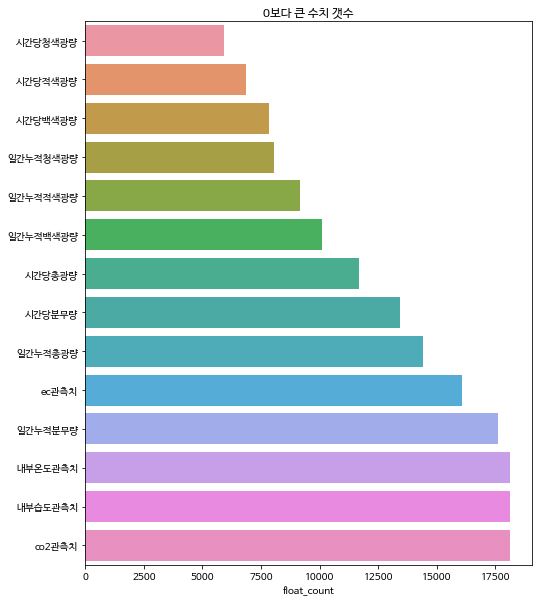

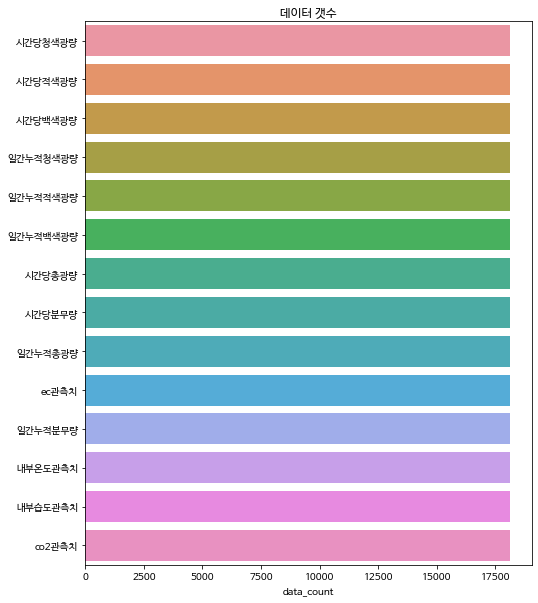

In [ ]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

In [70]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [71]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

max_bin: 511. RMSE:  2.878
max_bin:2047. RMSE:  2.878
max_bin:4095. RMSE:  2.878
Best max_bin: 511


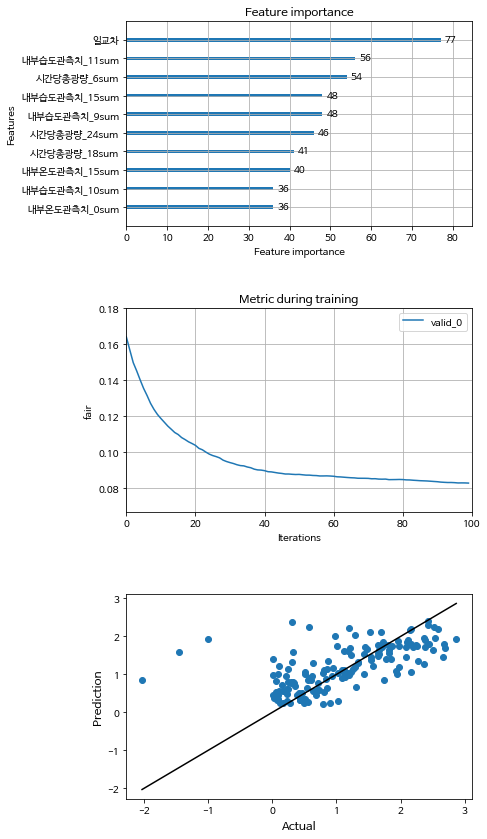

Features Importance Split & Gain...
           feature  split       gain
41   내부습도관측치_10sum     36  15.486762
37    내부습도관측치_9sum     48   5.971727
60   내부온도관측치_15sum     40   4.237138
27     시간당총광량_6sum     54   4.147057
75    시간당총광량_18sum     41   4.077882
45   내부습도관측치_11sum     56   4.069464
48   내부온도관측치_12sum     34   3.401805
100            일교차     77   2.515306
44   내부온도관측치_11sum     25   2.388045
61   내부습도관측치_15sum     48   1.882160
92   내부온도관측치_23sum     24   1.690076
52   내부온도관측치_13sum     15   1.595153
93   내부습도관측치_23sum     26   1.474112
24    내부온도관측치_6sum     22   1.454514
67    시간당총광량_16sum     19   1.438702
79    시간당총광량_19sum     28   1.340171
19     시간당총광량_4sum      6   1.230183
73   내부습도관측치_18sum     15   1.228420
99    시간당총광량_24sum     46   1.207599
35     시간당총광량_8sum     15   1.183784
21    내부습도관측치_5sum     20   1.180216
53   내부습도관측치_13sum     19   1.162685
33    내부습도관측치_8sum     29   1.159545
85   내부습도관측치_21sum     26   1.118405
36    내부온도관측치_9sum     21   1.113689
94

In [155]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")

In [156]:
max_bin = tuning_max_bin()
train_x, train_y = load_train()

RepNo = 5                                                                       # 품목 갯수
for rep in range(1, RepNo+1):
    print(f"Learning and Predicting for RepNo: {rep}")
    test_x, test_y = load_test(TestNo=rep)
    
    if (rep == 1):                                                              # 학습은 첫번째에만 하도록 한다.
        model, _, _, cv_preds = run_lgb({'max_bin':max_bin}, train_x, train_y, None, None, test_x, None)
        pred_Y = cv_preds.values
    else:
        pred_Y = model.predict(test_x)                                          # 두번째 부터는 학습된 모델로 추론만 한다.

    test_y['predicted_weight_g'] = pred_Y
    test_y['predicted_weight_g'] = test_y['predicted_weight_g'].cumsum()
    test_y.index= test_y.index.day

    test_y.to_csv(RESULTS_DIR + f'TEST_{rep:02d}.csv')
import zipfile
os.chdir(RESULTS_DIR)
submission = zipfile.ZipFile("submission.zip", 'w')
for rep in range(1, RepNo+1):
    path = f'TEST_{rep:02d}.csv'
    submission.write(path)
submission.close()
print(f'Saved {RESULTS_DIR}submission.zip')
os.chdir("..")

max_bin: 511. RMSE:  2.878
max_bin:2047. RMSE:  2.878
max_bin:4095. RMSE:  2.878
Best max_bin: 511
Learning and Predicting for RepNo: 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [157]:
test_y

,predicted_weight_g
시간,
1,0.690739
2,1.946289
3,1.834108
4,2.076505
5,2.388940
6,2.870087
7,2.700214
8,3.198312
9,3.987650
